# Image Classification

In this notebook, we will classify different kinds of beverages you might find in the fridge.

Check out fastai version.

In [1]:
import fastai
fastai.__version__

'1.0.45'

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [3]:
import sys
sys.path.append("../")
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from pathlib import Path
from ic_utils.datasets import Urls, unzip_url, data_path

Set some parameters. We'll use the `unzip_url` helper function to download and unzip our data.

In [4]:
DATA_PATH     = unzip_url(Urls.fridge_objects, overwrite=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## File Structure for Image Classification

In this notebook, we'll use images from the `fridge_objects` dataset, which has been downloaded and unzip to  `image_classification/data`.

Lets set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [5]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/home/jiata/code/cvbp/image_classification/data/fridgeObjects/milk_bottle'),
 PosixPath('/home/jiata/code/cvbp/image_classification/data/fridgeObjects/carton'),
 PosixPath('/home/jiata/code/cvbp/image_classification/data/fridgeObjects/water_bottle'),
 PosixPath('/home/jiata/code/cvbp/image_classification/data/fridgeObjects/can')]

You'll notice that we have four different folders inside:
- `/milk_bottle`
- `/carton`
- `/water_bottle`
- `/can`

The most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

Good thing our data is already structured in that format!

## Loading images with fast.ai

To use fastai, we want to create an ImageDataBunch so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

In [6]:
np.random.seed(42)
data = ImageItemList \
    .from_folder(path) \
    .random_split_by_pct(valid_pct=0.2, seed=10) \
    .label_from_folder() \
    .transform(size=IMAGE_SIZE) \
    .databunch(bs=BATCH_SIZE) \
    .normalize(imagenet_stats)

Lets take a look at our data using the databunch we created.

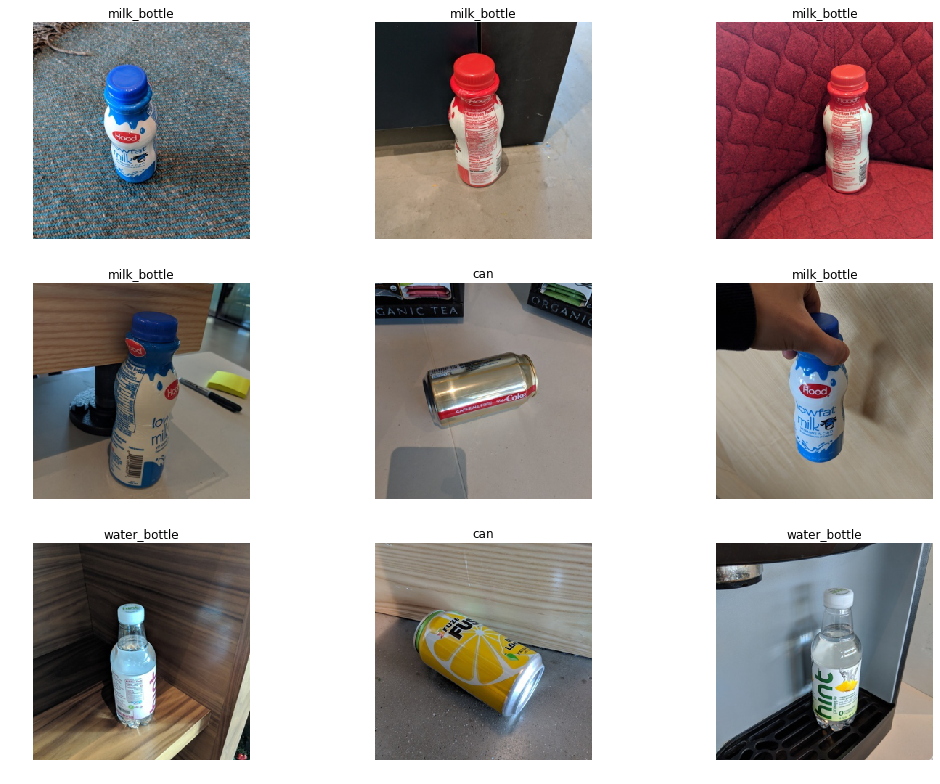

In [7]:
data.show_batch(rows=3, figsize=(15,11))

Lets see all available classes:

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


## Training

For the model, we use a concolutional neural network. 

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. 

With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and a performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train imagenet. 

In [9]:
learn = create_cnn(data, ARCHITECTURE, metrics=accuracy)

Unfreeze our CNN so that we're training all the layers.

In [10]:
learn.unfreeze()

We can call the `fit` function to train the last layer of the dnn.

In [11]:
learn.fit(EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy
1,1.528462,0.900746,0.730769
2,1.043772,0.612984,0.884615
3,0.770559,0.389264,0.961538
4,0.587021,0.238623,1.000000
5,0.458909,0.147429,1.000000


## Evaluating

To evaluate our model, lets take a look at the accuracy on the validation set.

In [12]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {float(metric)}')

Accuracy on validation set: 1.0


When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

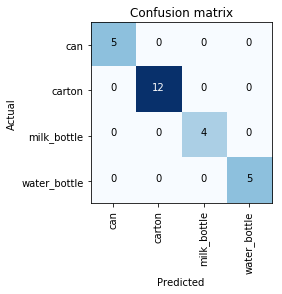

In [14]:
interp.plot_confusion_matrix()

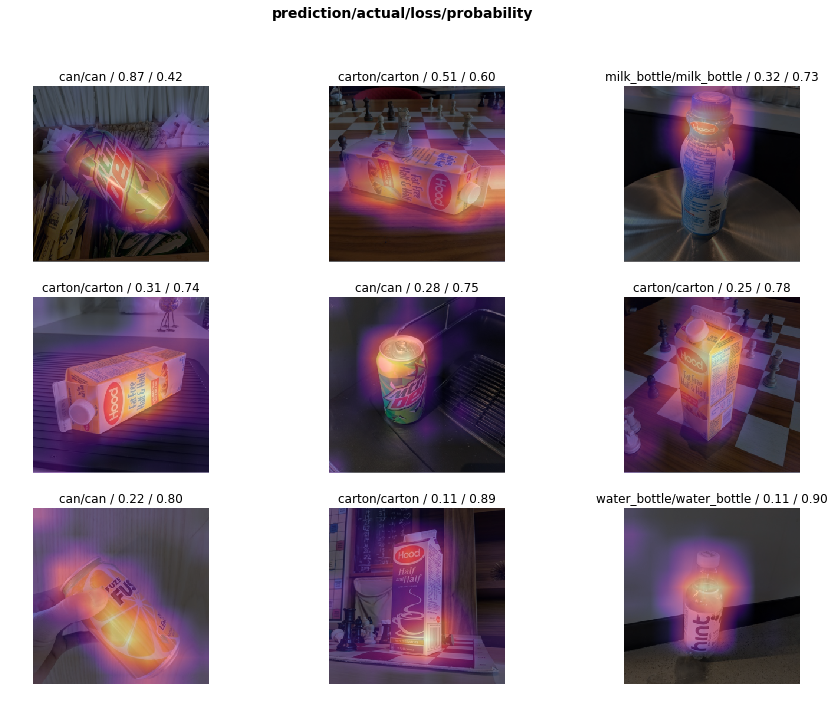

In [15]:
interp.plot_top_losses(9, figsize=(15,11))